This notebook is my attempt at developing a DDPG model for stock market investment, training and testing will be done on the DJIA.

Code based on https://github.com/keras-team/keras-io/blob/master/examples/rl/ddpg_pendulum.py and https://arxiv.org/abs/1811.07522 and the DDPG original paper

In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
from enviroment import Simulate_Portfolio
from datetime import datetime, timedelta
import keras
import yfinance as yf


Create enviroment and datasets

In [2]:
training_years = 6
validation_years = 1
testing_years = 1
start_datetime = datetime.now() - timedelta(weeks=52*training_years)
validation_datetime = datetime.now()  - timedelta(weeks=52*validation_years)
testing_years = datetime.now() - timedelta(weeks = 52*testing_years)

name = 'GOOG'

porfolio = Simulate_Portfolio(start_datetime)
porfolio.add_investment(name)
initial_state = porfolio.return_state(name)


In [3]:
df1 = porfolio.investments['GOOG'].history(start = start_datetime, end = datetime.now(), interval = '1d')

df1.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-08-07 00:00:00-04:00,57.458455,58.574074,57.141541,58.352642,28886000,0.0,0.0
2019-08-08 00:00:00-04:00,58.792033,59.894481,58.304433,59.884045,29360000,0.0,0.0
2019-08-09 00:00:00-04:00,59.545551,59.838310,58.830449,59.049500,21314000,0.0,0.0
2019-08-12 00:00:00-04:00,58.612101,58.897904,58.038609,58.388432,20060000,0.0,0.0
2019-08-13 00:00:00-04:00,58.226891,59.883043,58.226891,59.509762,25888000,0.0,0.0


In [ ]:
plt.plot(df['Close'])

In [4]:
df1 = df1['Close']

df1.head()

Date
2019-08-07 00:00:00-04:00    58.352642
2019-08-08 00:00:00-04:00    59.884045
2019-08-09 00:00:00-04:00    59.049500
2019-08-12 00:00:00-04:00    58.388432
2019-08-13 00:00:00-04:00    59.509762
Name: Close, dtype: float64

Supporting Functions

In [5]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)
            
            
def reset_enviroment():
    
    training_years = 6
    validation_years = 1
    testing_years = 1
    start_datetime = datetime.now() - timedelta(weeks=52*training_years)
    validation_datetime = datetime.now()  - timedelta(weeks=52*validation_years)
    testing_years = datetime.now() - timedelta(weeks = 52*testing_years)

    porfolio = Simulate_Portfolio(start_datetime)
    porfolio.add_investment(name)
    initial_state = porfolio.return_state(name)
    
    return initial_state, porfolio

def policy(state, noise_obj, actor):
    sampled_actions = keras.ops.squeeze(actor(state))
    noise = noise_obj()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise


    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1, 1)

    return [np.squeeze(legal_action)]

def perform_action(action, porfolio, prev_state):
    # :: action, portfolio, prev_state -> state, reward
    
    prev_net = porfolio.get_portfolio_net()
    
    holdings = prev_state[1]
    balance = prev_state[2]
    
    if 1>= action >= 0:
        value = max(balance, 0) * action
    elif -1<= action < 0:
        value = holdings * (action+1)
    else:
        raise ValueError(f" Action must be between -1 and 1, action {action} ")
    
   # print(f'Updated value: {value}, action: {action}, state:{prev_state}')
   
   
    try:
        porfolio.update_investment(name, value)
    except:
        raise ValueError(f"Why tf: {value}, action: {action}, state: {prev_state}, 1: {max(balance, 0) * action}, 2: {holdings * (action+1)} ")

    
    porfolio.next_timestep()
    
    
    reward = porfolio.get_portfolio_net() - prev_net
    
   # print(f'Updated state: {porfolio.return_state(name)} with reward: {reward}')

    return porfolio.return_state(name), reward, value - holdings

        
def update_target(target, original, tau):
    target_weights = target.get_weights()
    original_weights = original.get_weights()

    for i in range(len(target_weights)):
        target_weights[i] = original_weights[i] * tau + target_weights[i] * (1 - tau)

    target.set_weights(target_weights)
    

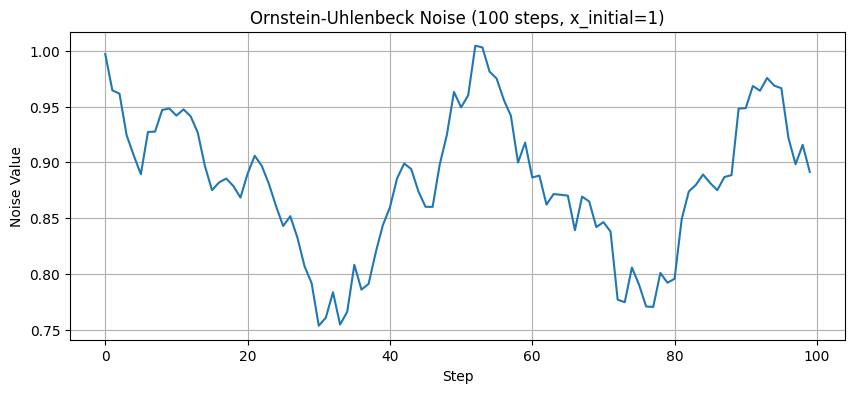

In [6]:
"""Testing the noise setup"""

OUActionNoise

noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(0.2) * np.ones(1), x_initial=np.ones(1))
noise.reset()
x_vals = []
for _ in range(100):
    x = noise()
    x_vals.append(x[0])

plt.figure(figsize=(10, 4))
plt.plot(x_vals)
plt.title("Ornstein-Uhlenbeck Noise (100 steps, x_initial=1)")
plt.xlabel("Step")
plt.ylabel("Noise Value")
plt.grid(True)
plt.show()


Model Setup

In [7]:
from keras import layers
from tensorflow.keras.layers import LeakyReLU

num_states = 3
num_actions = 1


def get_actor():

    last_init = keras.initializers.RandomUniform(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(64)(inputs)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64, activation="sigmoid")(out)
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)

    outputs = outputs * 1
    model = keras.Model(inputs, outputs)
    return model


def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states,))
    state_out = layers.Dense(16, activation="relu")(state_input)
    state_out = layers.Dense(32, activation="relu")(state_out)

    # Action as input
    action_input = layers.Input(shape=(num_actions,))
    action_out = layers.Dense(32, activation="relu")(action_input)

    # Both are passed through separate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])

    out = layers.Dense(64)(concat)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64)(out)
    out = LeakyReLU(alpha=0.1)(out)
    out = layers.Dense(64, activation="sigmoid")(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = keras.Model([state_input, action_input], outputs)

    return model





Training Hyperparams

In [8]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

actor_model = get_actor()
critic_model = get_critic()

target_actor = get_actor()
target_critic = get_critic()

# Making the weights equal initially
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())


# Learning rate for actor-critic models
critic_lr = 0.002
actor_lr = 0.001

critic_optimizer = keras.optimizers.Adam(critic_lr)
actor_optimizer = keras.optimizers.Adam(actor_lr)


# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.01

c:\Users\morus\anaconda3\envs\tf\lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Buffer

In [9]:
class Buffer:
    def __init__(self, models, buffer_capacity=100_000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))

    def record(self, obs_tuple):
        
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]

        self.buffer_counter += 1
        
    @tf.function
    def update(
        self,
        state_batch,
        action_batch,
        reward_batch,
        next_state_batch,
    ):
        
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch, training = True)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions], training = True)
            
            critic_value = critic_model([state_batch, action_batch], training = True)
            critic_loss = keras.ops.mean(keras.ops.square(y - critic_value))
            
        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(zip(critic_grad, critic_model.trainable_variables))
        
        with tf.GradientTape() as tape:
            actions = actor_model(state_batch, training = True)
            critic_value = critic_model([state_batch, actions], training = True)
            actor_loss = -keras.ops.mean(critic_value)
            
        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )
        
    def learn(self):
        
        record_range = min(self.buffer_counter, self.buffer_capacity)
        
        batch_indices = np.random.choice(record_range, self.batch_size)
        state_batch = keras.ops.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = keras.ops.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = keras.ops.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = keras.ops.cast(reward_batch, dtype="float32")
        next_state_batch = keras.ops.convert_to_tensor(
            self.next_state_buffer[batch_indices]
        )

        self.update(state_batch, action_batch, reward_batch, next_state_batch)




Main

In [ ]:
total_episodes = 100

buffer = Buffer(50000, 64)

# To store reward history of each episode
ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []

start_time = start_datetime
end_time = validation_datetime
ep_profit = []
    
for ep in range(total_episodes):
    
    ep_start = datetime.now()
    prev_state, porfolio = reset_enviroment()
    episodic_reward = 0
    step = 0
    
    episodic_actions = []
    episodic_val_diff = []
    episodic_timesteps = []
    episodic_full_state = []

    print(f"Starting episode: {ep}, with datetime {porfolio.datetime.strftime('%d-%m-%Y')}, ending at {end_time.strftime('%d-%m-%Y')}, state: {prev_state}")
    
    while porfolio.datetime < end_time:
        
        tf_prev_state = keras.ops.expand_dims(
            keras.ops.convert_to_tensor(prev_state), 0
        )
        
        action = policy(tf_prev_state, ou_noise, actor_model)
        
        state, reward, value_change = perform_action(action[0], porfolio, prev_state)
        
                
        buffer.record((prev_state, action, reward, state))
        episodic_reward += reward
        
        buffer.learn()

        update_target(target_actor, actor_model, tau)
        update_target(target_critic, critic_model, tau)

        episodic_actions.append(action)
        episodic_val_diff.append(value_change)
        episodic_full_state.append([prev_state])

        prev_state = state 

        step+=1

        
    ep_reward_list.append(episodic_reward)
    
    ep_profit.append(porfolio.calc_profit())
    
    avg_reward = np.mean(ep_reward_list[-40:])
    
    ep_end = datetime.now()
    elapsed = ep_end - ep_start
    minutes, seconds = divmod(elapsed.total_seconds(), 60)
    try:
        print(f"Episode {ep}, with avarage {episodic_reward/step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")
    except:
        print(f"Episode {ep}, with avarage {episodic_reward, step}, time: {int(minutes)}m {int(seconds)}s, with {step} timesteps")

    print(f"Episode actions -- avg action: {np.mean(episodic_actions)}, latest:{np.mean(episodic_actions[-40:])}")
    print(f"Episodic value changes -- reward: {episodic_reward} avg change: {np.mean(episodic_val_diff)}, latest:{np.mean(episodic_val_diff[-40:])} \n")
    
    avg_reward_list.append(avg_reward)
    

    


Starting episode: 0, with datetime 06-08-2019, ending at 30-07-2024, state: [  58.15184021    0.         1000.        ]
Episode 0, with avarage 0.2498420903492402, time: 0m 36s, with 1253 timesteps
Episode actions -- avg action: 0.4503725019196763, latest:0.33708605116860435
Episodic value changes -- reward: 313.052139207598 avg change: 0.041558618350474315, latest:-0.3556281693962234 

Starting episode: 1, with datetime 06-08-2019, ending at 30-07-2024, state: [  58.15184021    0.         1000.        ]
Episode 1, with avarage 0.07437584040284319, time: 0m 31s, with 1253 timesteps
Episode actions -- avg action: -0.21900118258663354, latest:-0.49471714376735554
Episodic value changes -- reward: 93.19292802476252 avg change: -0.074375840402842, latest:-4.209369521904837e-188 

Starting episode: 2, with datetime 06-08-2019, ending at 30-07-2024, state: [  58.1518364    0.        1000.       ]
Episode 2, with avarage 0.020348460485803157, time: 0m 30s, with 1253 timesteps
Episode actions 

In [15]:
prices = np.array(episodic_full_state)[:,:,0]
holdings = np.array(episodic_full_state)[:,:,1]
balance = np.array(episodic_full_state)[:,:,2]



print(prices)

[[ 58.15184021]
 [ 58.35264206]
 [ 59.88404083]
 ...
 [168.35177612]
 [167.87408447]
 [170.31237793]]


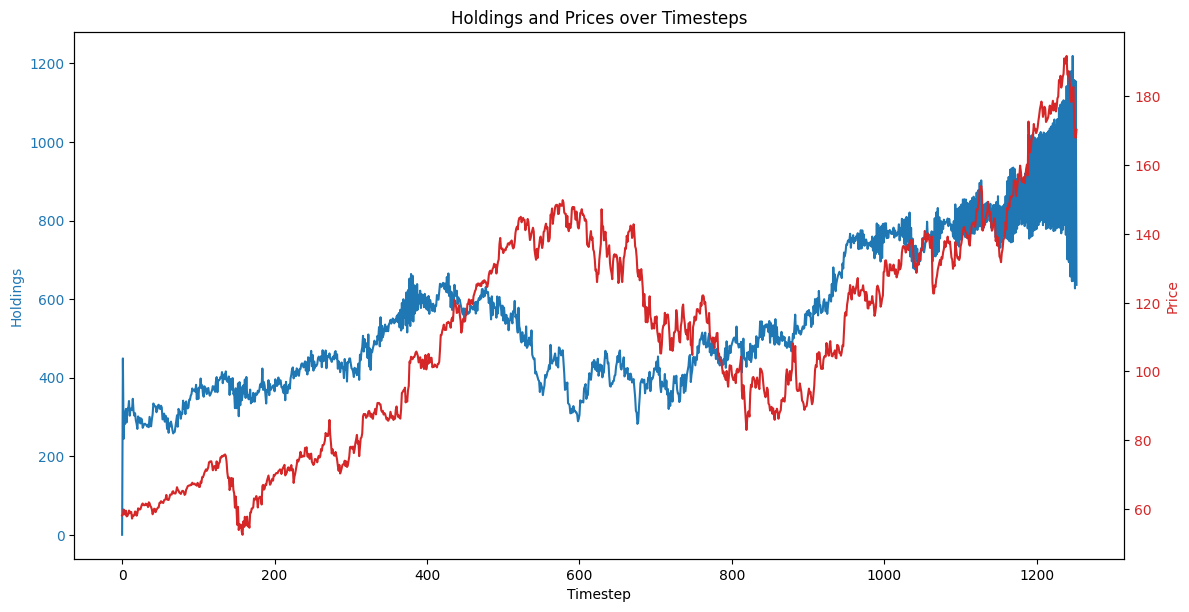

In [16]:
fig, ax1 = plt.subplots(figsize=(12, 6))

color = 'tab:blue'
ax1.set_xlabel('Timestep')
ax1.set_ylabel('Holdings', color=color)
ax1.plot(holdings, color=color, label='Holdings')
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Price', color=color)
ax2.plot(prices, color=color, label='Price')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()
plt.title('Holdings and Prices over Timesteps')
plt.show()

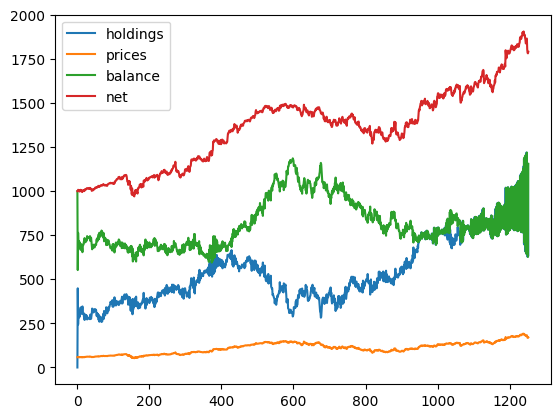

In [42]:
timestep = list(range(len(holdings)))


plt.plot(timestep, holdings, label = 'holdings')
plt.plot(timestep, prices, label = 'prices')
plt.plot(timestep, balance, label = 'balance')
plt.plot(timestep, balance + holdings, label = 'net')
plt.legend()

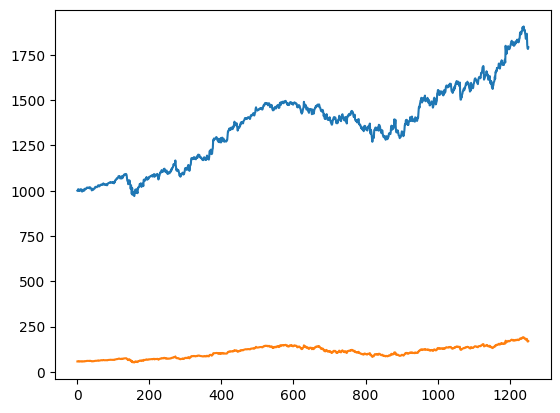

In [33]:
net = holdings + balance

plt.plot(timestep, net)
plt.plot(prices)

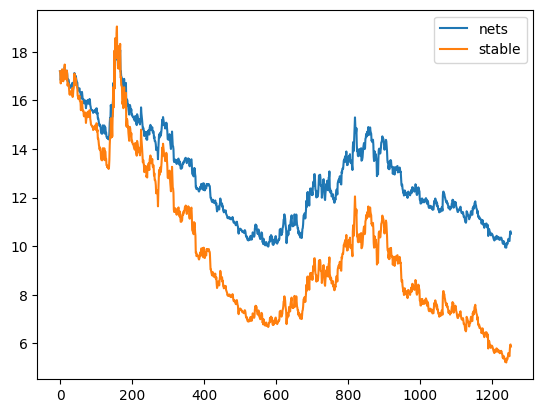

In [32]:
plt.plot(net/prices, label = 'nets')
plt.plot(net[0]/prices, label = 'stable')

plt.legend()

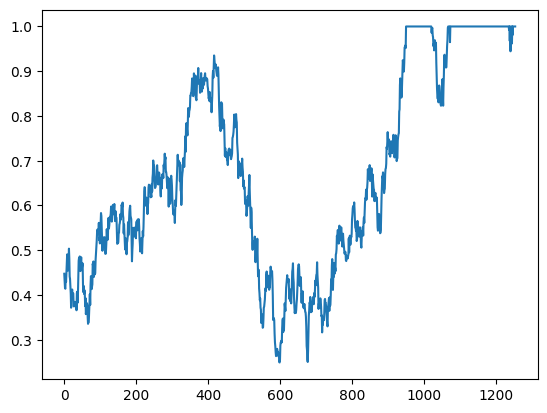

In [34]:
plt.plot(episodic_actions)

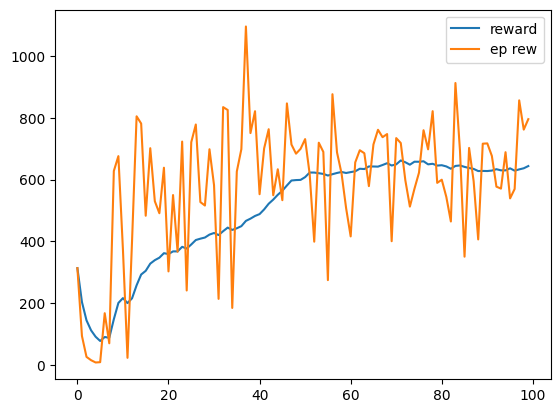

In [41]:
plt.plot(avg_reward_list, label = 'reward')
plt.plot(ep_reward_list, label = 'ep rew')
plt.legend()